In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

[*********************100%***********************]  3 of 3 completed


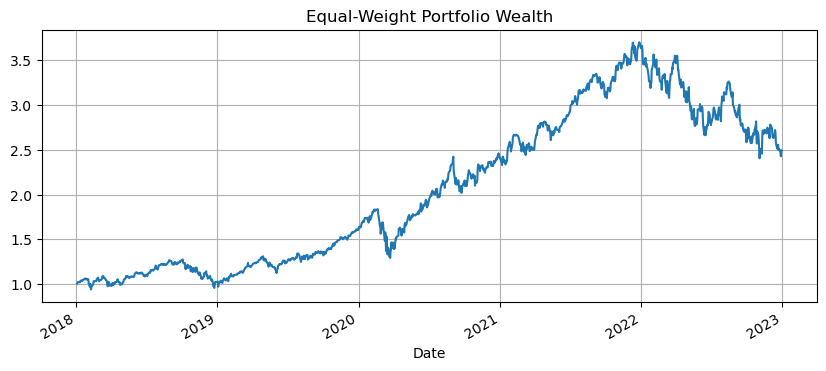

In [103]:
tickers = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2018-01-01'
end_date = '2023-01-01'

data = yf.download(tickers, start=start_date, end=end_date)['Close']
prices = data.dropna()

returns = np.log(prices / prices.shift(1)).dropna() # the logarithmic rate of return

# Equal-weight benchmark strategy
equal_weight = np.array([1/3]*3)
equal_return = (returns @ equal_weight)
equal_wealth = np.exp(equal_return.cumsum())
equal_wealth.name = 'Equal Weight'

equal_wealth.plot(title="Equal-Weight Portfolio Wealth", figsize=(10, 4))
plt.grid(True)
plt.show()


#### Performance evaluation function (CAGR, Sharpe, Max Drawdown)

In [104]:
def evaluate_performance(wealth_series):
    returns = wealth_series.pct_change().dropna()
    cagr = (wealth_series[-1]/wealth_series[0])**(252/len(wealth_series)) - 1
    sharpe = returns.mean() / returns.std() * np.sqrt(252)
    max_dd = ((wealth_series / wealth_series.cummax()) - 1).min()
    return {'CAGR': cagr, 'Sharpe': sharpe, 'Max Drawdown': max_dd}

baseline_perf = evaluate_performance(equal_wealth)
baseline_df = pd.DataFrame(baseline_perf, index=['Baseline_Perf'])
baseline_df

/var/folders/l3/q9v7pm6d4csg_rn4z8rtgx_00000gn/T/ipykernel_14724/684895775.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (wealth_series[-1]/wealth_series[0])**(252/len(wealth_series)) - 1


,CAGR,Sharpe,Max Drawdown
Baseline_Perf,0.198895,0.766556,-0.349944


# DQN Model Training

In [105]:
# network structure
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.model = DQN(state_dim, action_dim)
        self.target = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.batch_size = 32
        self.update_target()

    def update_target(self):
        self.target.load_state_dict(self.model.state_dict())

    def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, 2)
        with torch.no_grad():
            q = self.model(torch.FloatTensor(state))
            return torch.argmax(q).item()

    def store(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        s, a, r, s_, done = zip(*batch)
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a)
        r = torch.FloatTensor(r)
        s_ = torch.FloatTensor(s_)
        done = torch.FloatTensor(done)

        q = self.model(s).gather(1, a.unsqueeze(1)).squeeze()
        max_q_ = self.target(s_).max(1)[0]
        target = r + self.gamma * max_q_ * (1 - done)
        loss = nn.MSELoss()(q, target.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


## DQN strategy training

In [106]:
window = 10
agent = DQNAgent(state_dim=3*window, action_dim=3)
wealth = []
eps = 1.0

state = returns.iloc[:window].values.flatten()
portfolio_value = 1.0
history = [portfolio_value]

for t in range(window, len(returns)-1):
    action_idx = agent.act(state, eps)
    action = np.zeros(3)
    action[action_idx] = 1  # one-hot
    next_ret = returns.iloc[t+1].values
    ret = np.dot(action, next_ret)
    reward = ret
    portfolio_value *= np.exp(ret)
    next_state = returns.iloc[t-window+1:t+1].values.flatten()
    agent.store(state, action_idx, reward, next_state, 0)
    agent.train()
    state = next_state
    history.append(portfolio_value)
    eps = max(eps * 0.995, 0.01)
    if t % 50 == 0:
        agent.update_target()

dqn_wealth = pd.Series(history, index=returns.index[window:window+len(history)])
dqn_perf = evaluate_performance(dqn_wealth)

/var/folders/l3/q9v7pm6d4csg_rn4z8rtgx_00000gn/T/ipykernel_14724/684895775.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (wealth_series[-1]/wealth_series[0])**(252/len(wealth_series)) - 1


## DQN Visual risk analysis of strategic behavior

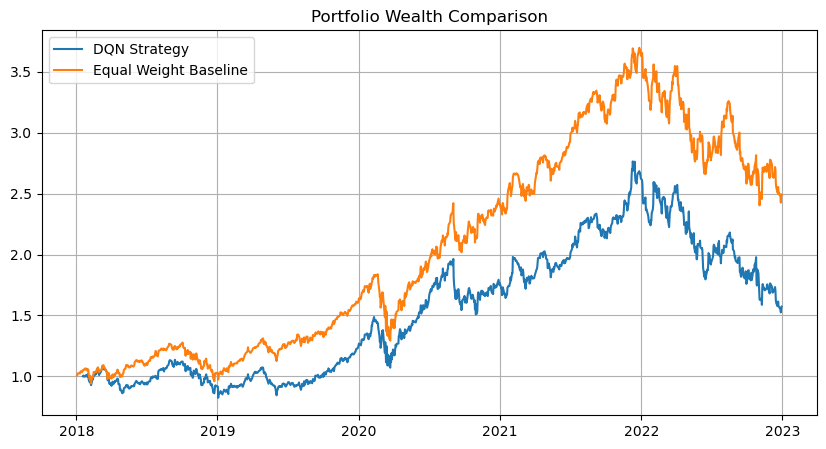

,CAGR,Sharpe,Max Drawdown
DQN_Perf,0.095672,0.442541,-0.448397


In [107]:
plt.figure(figsize=(10, 5))
plt.plot(dqn_wealth, label='DQN Strategy')
plt.plot(equal_wealth, label='Equal Weight Baseline')
plt.legend()
plt.title('Portfolio Wealth Comparison')
plt.grid(True)
plt.show()

dqn_df = pd.DataFrame(dqn_perf, index=['DQN_Perf'])
dqn_df

# PPO
## Define the PPO policy network and agents

In [108]:
class PPOActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(PPOActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        probs = self.actor(x)
        value = self.critic(x)
        return probs, value

In [109]:
class PPOAgent:
    def __init__(self, input_dim, action_dim, lr=3e-4, gamma=0.99, clip_epsilon=0.2):
        self.model = PPOActorCritic(input_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon

    def select_action(self, state):
        state = torch.FloatTensor(state)
        probs, _ = self.model(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), dist.entropy()

    def evaluate(self, states, actions):
        probs, values = self.model(torch.FloatTensor(states))
        dist = torch.distributions.Categorical(probs)
        action_logprobs = dist.log_prob(torch.LongTensor(actions))
        dist_entropy = dist.entropy()
        return action_logprobs, torch.squeeze(values), dist_entropy

## Train the PPO strategy

In [110]:
def compute_gae(rewards, values, gamma=0.99, lam=0.95):
    advantages = []
    gae = 0
    values = values + [0]
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] - values[t]
        gae = delta + gamma * lam * gae
        advantages.insert(0, gae)
    return advantages

In [111]:
def train_ppo(agent, trajectories, epochs=5):
    states = torch.FloatTensor(trajectories['states'])
    actions = trajectories['actions']
    old_logprobs = torch.stack(trajectories['logprobs']).detach()
    rewards = trajectories['rewards']
    values = trajectories['values']
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + agent.gamma * G
        returns.insert(0, G)
    returns = torch.FloatTensor(returns)
    advantages = compute_gae(rewards, values)
    advantages = torch.FloatTensor(advantages)

    for _ in range(epochs):
        logprobs, values_pred, entropies = agent.evaluate(states, actions)
        ratios = torch.exp(logprobs - old_logprobs)
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - agent.clip_epsilon, 1 + agent.clip_epsilon) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = nn.MSELoss()(values_pred, returns)
        entropy_loss = -entropies.mean()
        total_loss = actor_loss + 0.5 * critic_loss + 0.01 * entropy_loss

        agent.optimizer.zero_grad()
        total_loss.backward()
        agent.optimizer.step()


## PPO strategy and the combined value

In [112]:
window = 10
state_dim = 3 * window
action_dim = 3
agent = PPOAgent(state_dim, action_dim)

portfolio_value = 1.0
wealth_trace = [portfolio_value]
trajectory = {'states': [], 'actions': [], 'logprobs': [], 'rewards': [], 'values': []}

returns_np = returns.values
for t in range(window, len(returns) - 1):
    state = returns_np[t - window:t].flatten()
    action, logprob, entropy = agent.select_action(state)
    weights = np.zeros(3)
    weights[action] = 1
    reward = np.dot(returns_np[t + 1], weights)
    portfolio_value *= np.exp(reward)
    wealth_trace.append(portfolio_value)

    _, value = agent.model(torch.FloatTensor(state))
    trajectory['states'].append(state)
    trajectory['actions'].append(action)
    trajectory['logprobs'].append(logprob)
    trajectory['rewards'].append(reward)
    trajectory['values'].append(value.item())

    if len(trajectory['rewards']) >= 64:
        train_ppo(agent, trajectory)
        for k in trajectory: trajectory[k] = []


## visualization and performance evaluation

/var/folders/l3/q9v7pm6d4csg_rn4z8rtgx_00000gn/T/ipykernel_14724/684895775.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (wealth_series[-1]/wealth_series[0])**(252/len(wealth_series)) - 1


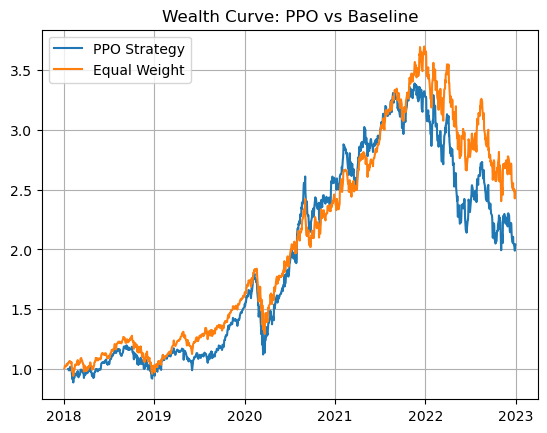

,CAGR,Sharpe,Max Drawdown
DQN_Perf,0.15482,0.607513,-0.412752


In [113]:
ppo_wealth = pd.Series(wealth_trace, index=returns.index[window:window+len(wealth_trace)])
ppo_perf = evaluate_performance(ppo_wealth)

plt.plot(ppo_wealth, label='PPO Strategy')
plt.plot(equal_wealth, label='Equal Weight')
plt.legend()
plt.title("Wealth Curve: PPO vs Baseline")
plt.grid(True)
plt.show()

ppo_df = pd.DataFrame(ppo_perf, index=['DQN_Perf'])
ppo_df

In [114]:
comparison = pd.DataFrame({
    'Equal-Weight': baseline_perf,
    'DQN': dqn_perf,
    'PPO': ppo_perf
}).T
display(comparison)

,CAGR,Sharpe,Max Drawdown
Equal-Weight,0.198895,0.766556,-0.349944
DQN,0.095672,0.442541,-0.448397
PPO,0.154820,0.607513,-0.412752
